In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, QuantumRegister, ClassicalRegister
from qiskit.circuit import Gate
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator
from qiskit.circuit.library import QFT, XGate
from qiskit.extensions import UnitaryGate
from scipy.linalg import expm
# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

# Defining sim-AD chain

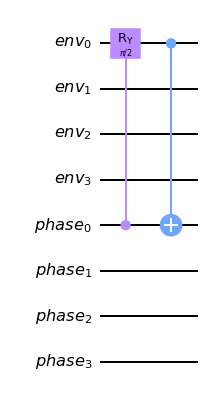

In [2]:
def sim_AD(num_qubits: int, damped_qubit: int, theta: float):
    
    #Defines a sim-AD block
    #
    #Inputs: 
    #num_qubits: size of the quantum registers
    #damped_qubit: position of the qubit that will undergo damping
    #theta: parameter of the CRy gate
    #
    #Output:
    #Circuit with phase and environment quantum registers
    
    qr_phase = QuantumRegister(num_qubits, 'phase')
    qr_env = QuantumRegister(num_qubits, 'env')
    
    qc = QuantumCircuit(qr_env, qr_phase)
    
    qc.cry(theta, control_qubit = qr_phase[damped_qubit], target_qubit= qr_env[damped_qubit])
    
    qc.cnot(qr_env[damped_qubit], qr_phase[damped_qubit])
    
    
    return qc.to_gate(label = 'sim-AD_{}[{}]'.format(damped_qubit, theta))
    
    
    
num_qubits_test = 4
damped_qubit_test = 0
theta_test = np.pi/2
    
sim_AD_gate = sim_AD(num_qubits_test, damped_qubit_test, theta_test)
qr_phase = QuantumRegister(num_qubits_test, 'phase')
qr_env = QuantumRegister(num_qubits_test, 'env')    
qc = QuantumCircuit(qr_env, qr_phase)
qc.append(sim_AD_gate, qr_env[:] + qr_phase[:])
qc.decompose().draw()
    

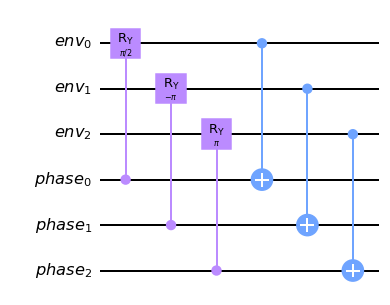

In [3]:
def sim_AD_chain(num_qubits: int, thetas: list):
    
    #Defines a sim-AD chain (no measurement included)
    #
    #Inputs: 
    #num_qubits: size of the quantum registers
    #theta: parameters of the CRy gates, ordered according to the qubits in the registers
    #
    #Output:
    #Circuit with phase and environment quantum registers
    
    qr_phase = QuantumRegister(num_qubits, 'phase')
    qr_env = QuantumRegister(num_qubits, 'env')
    qc = QuantumCircuit(qr_env, qr_phase)
    
    for j in range(num_qubits):
        sim_AD_gate_j = sim_AD(num_qubits = num_qubits, damped_qubit = j, theta = thetas[j])
        qc.append(sim_AD_gate_j, qr_env[:] + qr_phase[:])
    
    return qc




num_qubits = 3
thetas = [np.pi/2, -np.pi, np.pi, -np.pi/2]
sim_AD_chain(num_qubits, thetas).decompose().draw()



# Phase Estimation

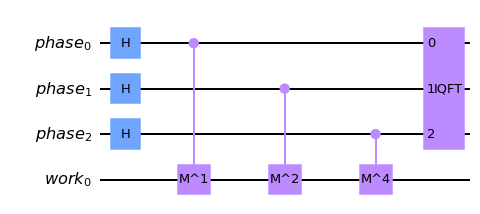

In [4]:
def QPE_circuit(work_qubits: int, phase_qubits: int, MGate: Gate):
    
    #Defines the QPE circuit
    #
    #Inputs: 
    #work_qubits: size of the work register
    #phase_qubits: size of the phase register
    #MGate: Gate object, operator M as in the article - Section (3.2.2)
    #theta: parameters of the CRy gates, ordered according to the qubits in the registers
    #
    #Output:
    #Circuit with work amd phase quantum registers

    
    qr_work = QuantumRegister(work_qubits, 'work')
    qr_phase = QuantumRegister(phase_qubits, 'phase')
    
    qc = QuantumCircuit(qr_phase, qr_work)
    
    qc.h(qr_phase[:])
    
    for j in range(phase_qubits):
        
        MGate_j = MGate.power(2**j)
        MGate_j.label = 'M^{}'.format(2**j)
        
        qc.append(MGate_j.control(), [qr_phase[j]] + qr_work[:])
        
    qft = QFT(num_qubits=phase_qubits, inverse=True, insert_barriers=False)
    
    qc.append(qft, qr_phase[:])
    
    return qc


qc_test = QuantumCircuit(1)
qc_test.x
Mgate_test = qc_test.to_gate()

QPE_circuit(work_qubits = 1, phase_qubits = 3, MGate = Mgate_test).draw()

    
    
    
    
    

# Generating parameters from original HDLE

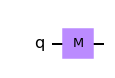

In [5]:
def Mgate_generate(A: np.array, normA: float, strictly_positive = True, L = 0):
    
    #Defines the M Gate as in article - Section (3.2.2) or Appendix B (Eq. 11)
    #
    #Inputs: 
    #A: evolution matrix from original HDLE
    #normA: 2-norm of A
    #strictly_positive: boolean for switching between both formulations
    #L: Hilbert space dimension for phase register (only required if strictly_positive = False)
    #
    #Output:
    #Gate object
    
    
    if strictly_positive:
        Ap = A/normA
    else:
        Ap = ((L-1)/(2*L))*A/normA + ((L+1)/(2*L))*np.identity(A.shape[0]) 
        
    M = expm(-2*(0+1j)*np.pi*Ap)
        
    MGate = UnitaryGate(M, label = 'M')
    
    return MGate

qc_test = QuantumCircuit(1)
A_test = np.array(((1, 2), (2, 1)))
L_test = 8
normA_test = np.linalg.norm(A_test, 2)

qc_test.append(Mgate_generate(A = A_test, normA = normA_test, strictly_positive = False, L = L_test), [0])
qc_test.draw()    

In [6]:
def thetas_generate(t: float, L:int, normA: float, strictly_positive = True): #According to eq. 6
    
    #Defines the theta parameters as in:
    #dissertation - Eq. 3.6 or Eq. 3.17 
    #article: Eq. 6 or 13
    #
    #Inputs: 
    #t: time variable from original HDLE
    #L: Hilbert space dimension for phase register
    #normA: 2-norm of A
    #strictly_positive: boolean for switching between both formulations
    #
    #Output:
    #Numpy array with parameter values

    
    thetas = []
    
    if strictly_positive:
        for k in range(int(np.log2(L))):
            arg_k = 2*np.exp(-normA*2**(k+1)*t/L)-1 # Eq. 3.6 or 6
            theta_k = np.arccos(arg_k)
            thetas.append(theta_k)
    else:
        for k in range(int(np.log2(L))):
            arg_k = 2*np.exp(-normA*2**(k+2)*t/(L-1))-1 # Eq. 3.17 or 13
            theta_k = np.arccos(arg_k)
            thetas.append(theta_k)
        
        
    return np.array(thetas)
    
thetas_generate(1, 8, 1, False)

array([1.44099591, 1.94140933, 2.49244149])

# Complete sim-AD circuit

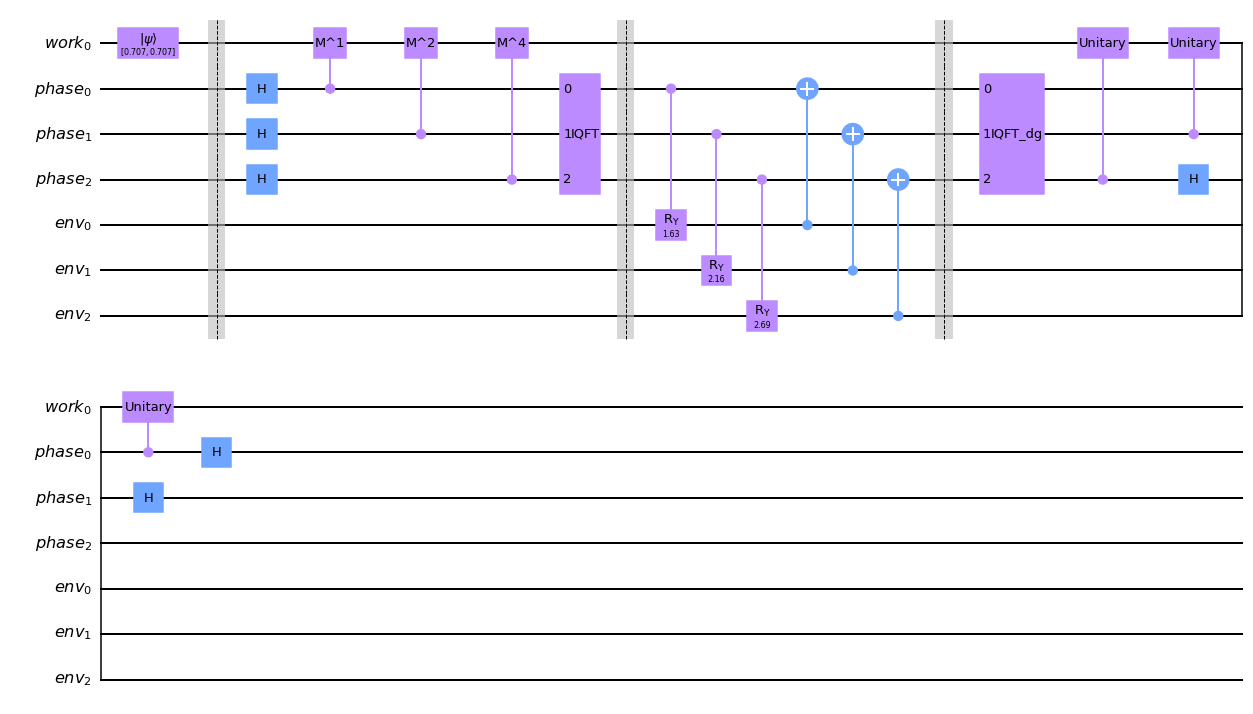

In [9]:
def sim_AD_HDLE(A:np.array, t:int, x0: np.array, L: int, strictly_positive = False):
    
    #Defines complete circuit (no measurements) for solving HDLE as in
    #dissertation: Figure 4
    #article: Figure 1
    #
    #Inputs: 
    #A: evolution matrix from original HDLE
    #t: time variable from original HDLE
    #x0: initial condition vector from original HDLE
    #L: Hilbert space dimension for phase register
    #strictly_positive: boolean for switching between both formulations
    #
    #Output:
    #Numpy array with parameter values
    
    
    work_qubits = int(np.log2(A.shape[0]))
    phase_qubits = int(np.log2(L))
    
    qr_env = QuantumRegister(phase_qubits, 'env')
    qr_phase = QuantumRegister(phase_qubits, 'phase')
    qr_work = QuantumRegister(work_qubits, 'work')
    
    qc = QuantumCircuit(qr_work, qr_phase, qr_env)
    
    x0ket = x0/np.linalg.norm(x0,2)
    qc.initialize(x0ket, qr_work[:])
    
    qc.barrier()
    
    normA = np.linalg.norm(A, 2)
    MGate = Mgate_generate(A, normA, strictly_positive, L)
    
    qc = qc.compose(QPE_circuit(work_qubits, phase_qubits, MGate), qr_phase[:]+ qr_work[:])
    qc.barrier()
    
    thetas = thetas_generate(t, L, normA, strictly_positive)
    
    qc += sim_AD_chain(phase_qubits, thetas).decompose()
    
    qc.barrier()
    
    qc = qc.compose(QPE_circuit(work_qubits, phase_qubits, MGate).inverse(), qr_phase[:]+ qr_work[:])
    
    
    return qc


A_test = np.array(((1, 2), (2, 1)))
x0_test = np.array((1, 1))
L_test = 8
t_test = 1
sim_AD_HDLE(A = A_test, t = t_test, x0 = x0_test, L=L_test, strictly_positive = True).draw()
    
    

# Noiseless simulation

Noiseless simulation function

In [8]:
from qiskit.aqua.operators import StateFn
from scipy.linalg import expm
from numpy.linalg import norm


def noiseless_state_simulation(A, t, x0, L, strictly_positive= False):

    #Uses StateFn module to simulate circuit
    #
    #Inputs: 
    #A: evolution matrix from original HDLE
    #t: time variable from original HDLE
    #x0: initial condition vector from original HDLE
    #L: Hilbert space dimension for phase register
    #strictly_positive: boolean for switching between both formulations
    #
    #Output:
    #Dictionary with simulation results, as explained in page 64 of the dissertation
    
    psi = StateFn(sim_AD_HDLE(A, t, x0, L, strictly_positive))
    
    psiket = psi.eval().to_matrix()[0:A.shape[0]]
    
    
    p_success = norm(psiket, 2)**2
        
    Q_sol = norm(x0, 2)*np.exp(norm(A, 2)*t)*psiket
    
    C_sol = expm(A*t).dot(x0)
    
    MSE = (1/A.shape[0])*norm(np.subtract(Q_sol,C_sol), 2)
    
    
    return {'p_success': p_success, 'Q_sol': Q_sol, 'C_sol': C_sol, 'MSE': MSE}
    
    

/opt/conda/lib/python3.8/site-packages/qiskit/aqua/__init__.py:86: DeprecationWarning: The package qiskit.aqua is deprecated. It was moved/refactored to qiskit-terra For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua', 'qiskit-terra')


# Problem examples

In [9]:
#Example 1.1: 

A_11 = np.array(((9/16, 7/16), (7/16, 9/16)))
x0_11 = np.array((1, 0))
L_11 = 8
t_11=1

noiseless_state_simulation(A_11, t_11, x0_11, L_11, strictly_positive = True)




/opt/conda/lib/python3.8/site-packages/qiskit/aqua/operators/operator_base.py:46: DeprecationWarning: The package qiskit.aqua.operators is deprecated. It was moved/refactored to qiskit.opflow (pip install qiskit-terra). For more information see <https://github.com/Qiskit/qiskit-aqua/blob/main/README.md#migration-guide>
  warn_package('aqua.operators', 'qiskit.opflow', 'qiskit-terra')


{'p_success': 0.586886971725221,
 'Q_sol': array([1.92571514-5.23812908e-15j, 0.79256669-3.30271242e-15j]),
 'C_sol': array([1.92571514, 0.79256669]),
 'MSE': 3.4644426580399385e-15}

In [59]:
#Example 1.2: 

A_12 = np.array(((9/16, 7/16), (7/16, 9/16)))
x0_12 = np.array((1, 0))
L_12 = 8
t_12 = 10

noiseless_state_simulation(A_12, t_12, x0_12, L_12, strictly_positive = True)

{'p_success': 0.5000000125549947,
 'Q_sol': array([11014.97806888-2.79075322e-11j, 11011.48772592-4.47577785e-11j]),
 'C_sol': array([11014.97806888, 11011.48772592]),
 'MSE': 3.693080295281057e-11}

In [60]:
# Example 2.1: 

A_21 = np.array(((1, 0), (0, 1.4/8)))
x0_21 = np.array((1, 1))
L_21 = 8
t_21 =1

noiseless_state_simulation(A_21, t_21, x0_21, L_21, strictly_positive = True)

{'p_success': 0.6197352743352638,
 'Q_sol': array([2.71828183-6.68896199e-16j, 1.33021101-1.05331930e-15j]),
 'C_sol': array([2.71828183, 1.19124622]),
 'MSE': 0.06948239425868574}

In [61]:
# Example 2.2: 

A_22 = np.array(((1, 0), (0, 1.4/8)))
x0_22 = np.array((1, 1))
L_22 = 16
t_22 =1

noiseless_state_simulation(A_22, t_22, x0_22, L_22, strictly_positive = True)

{'p_success': 0.6017305239003115,
 'Q_sol': array([2.71828183-1.21016393e-14j, 1.22612605-5.63948692e-15j]),
 'C_sol': array([2.71828183, 1.19124622]),
 'MSE': 0.01743991784733856}

In [62]:
# Example 2.3: 

A_23 = np.array(((1, 0), (0, 1.4/8)))
x0_23 = np.array((1, 1))
L_23 = 32
t_23 =1

noiseless_state_simulation(A_23, t_23, x0_23, L_23, strictly_positive = True)

{'p_success': 0.6011100808468363,
 'Q_sol': array([2.71828183-1.16633969e-14j, 1.22238133-5.81247731e-15j]),
 'C_sol': array([2.71828183, 1.19124622]),
 'MSE': 0.015567557339452032}

In [63]:
# Example 2.4: 

A_24 = np.array(((1, 0), (0, 1.4/8)))
x0_24 = np.array((1, 1))
L_24 = 64
t_24 =1

noiseless_state_simulation(A_24, t_24, x0_24, L_24, strictly_positive = True)

{'p_success': 0.5963759540995014,
 'Q_sol': array([2.71828183-1.24399316e-14j, 1.19342141-6.04697541e-15j]),
 'C_sol': array([2.71828183, 1.19124622]),
 'MSE': 0.0010875969058176116}

In [34]:
# Example 3.1 

A_31 = np.array(((-0.5, 0, 1.5, 0), (0, 1, 0, 1), (1.5, 0, -0.5, 0), (0, 1, 0, 1)))
x0_31 = np.array((0.5, 0, -0.5, 0))
L_31 = 4
t_31 =0.5

noiseless_state_simulation(A_31, t_31, x0_31, L_31, strictly_positive = False)





{'p_success': 0.018315638888734078,
 'Q_sol': array([ 0.18393972-8.59185635e-16j,  0.        +0.00000000e+00j,
        -0.18393972+8.78406790e-16j,  0.        +0.00000000e+00j]),
 'C_sol': array([ 0.18393972,  0.        , -0.18393972,  0.        ]),
 'MSE': 4.0938476872341587e-16}

In [35]:
# Example 3.2



A_31 = np.array(((-2/3, 0, 4/3, 0), (0, 2/3, 0, 4/3), (4/3, 0, -2/3, 0), (0, 4/3, 0, 2/3)))
weight = np.identity(A_31.shape[0])
zeros = np.zeros((A_31.shape[0], A_31.shape[0]))
normA_31 = norm(A_31, 2)


A_31 = np.concatenate((zeros, A_31), axis = 0)
A_32 = np.concatenate((normA_31* weight, zeros), axis = 0)

A_32 = np.concatenate([A_32, A_31], axis = 1)


x0_31 = np.array((0.5, 0, -0.5, 0))
y0_32 = (1/2)*np.array((1, 1, -1, -1))*norm(x0_31, 2)

x0_32 = np.concatenate((y0_32, x0_31), axis = 0)

L_32 = 4
t_32 =0.5

noiseless_state_simulation(A_32, t_32, x0_32, L_32, strictly_positive = False)



{'p_success': 0.5091578194443652,
 'Q_sol': array([ 0.96105776-5.98022002e-17j,  0.96105776-6.46951075e-16j,
        -0.96105776+4.00674742e-15j, -0.96105776+2.53887523e-15j,
         0.18393972+2.09307701e-16j,  0.        +0.00000000e+00j,
        -0.18393972+1.30477528e-15j,  0.        +0.00000000e+00j]),
 'C_sol': array([ 0.96105776,  0.96105776, -0.96105776, -0.96105776,  0.18393972,
         0.        , -0.18393972,  0.        ]),
 'MSE': 7.978767154385494e-16}